In [13]:
%matplotlib inline
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# a dataframe containing the data to be attacked
data: pd.DataFrame = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5reconstruction.csv")

# names of public identifier columns
pub = ["sex", "age", "educ", "latino", "black", "asian",
       "married", "divorced", "children", "disability",
       "militaryservice", "employed", "englishability"]

# variable to reconstruct
target = "uscitizen"

## Query Functions

In [5]:
def execute_subsetsums_exact(predicates):
    """Count the number of citizens that satisfy each predicate.
    Resembles a public query interface on a sequestered dataset.
    Computed as in equation (1).

    :param predicates: a list of predicates on the public variables
    :returns a 1-d np.ndarray of exact answers the subset sum queries"""
    return data[target].values @ np.stack([pred(data) for pred in predicates], axis=1)

# Problem 1.b
def execute_subsetsums_round(R, predicates):
    """Count the number of citizens that satisfy each predicate.
    Resembles a public query interface on a sequestered dataset.
    Computed as in equation (1).

    :param predicates: a list of predicates on the public variables
    :returns a 1-d np.ndarray of exact answers the subset sum queries"""
    raw = data[target].values @ np.stack([pred(data) for pred in predicates], axis=1)
    return [round(num/R)*R for num in raw]


def execute_subsetsums_noise(sigma, predicates):
    """Count the number of citizens that satisfy each predicate.
    Resembles a public query interface on a sequestered dataset.
    Computed as in equation (1).

    :param predicates: a list of predicates on the public variables
    :returns a 1-d np.ndarray of exact answers the subset sum queries"""
    raw = data[target].values @ np.stack([pred(data) for pred in predicates], axis=1)
    noise = np.random.normal(0, sigma, len(raw))
    return list(map(sum, zip(raw, noise)))


def execute_subsetsums_sample(t, predicates):
    """Count the number of citizens that satisfy each predicate.
    Resembles a public query interface on a sequestered dataset.
    Computed as in equation (1).

    :param predicates: a list of predicates on the public variables
    :returns a 1-d np.ndarray of exact answers the subset sum queries"""
    sz = len(data)
    sample = data.sample(n = t)
    raw = sample[target].values @ np.stack([pred(sample) for pred in predicates], axis=1)
    return [num*(sz/t) for num in raw]

In [6]:
if __name__ == "__main__":
    # EXAMPLE: writing and using predicates
    num_female_citizens, num_married_citizens = execute_subsetsums_exact([
        lambda data: data['sex'] == 1,      # "is-female" predicate
        lambda data: data['married'] == 1,  # "is-married" predicate
    ])
    #n1 = list(execute_subsetsums_exact([lambda data: data['sex'] == 1]))[0]
    #n2 = list(execute_subsetsums_round(5, [lambda data: data['sex'] == 1]))[0]
    #n3 = list(execute_subsetsums_noise(2, [lambda data: data['sex'] == 1]))[0]
    #n4 = list(execute_subsetsums_sample(50, [lambda data: data['sex'] == 1]))[0]
    #print(n1, n2, n3, n4)

## Random Predicate Generator

In [7]:
def make_random_predicate():
    """Returns a (pseudo)random predicate function by hashing public identifiers."""
    prime = 691
    desc = np.random.randint(prime, size=len(pub))
    # this predicate maps data into a 1-d ndarray of booleans
    #   (where `@` is the dot product and `%` modulus)
    return lambda data: ((data[pub].values @ desc) % prime % 2).astype(bool)

In [8]:
if __name__ == "__main__":
    # EXAMPLE: making and using a random predicate
    example_predicate = make_random_predicate()
    num_citizens_that_matched_random_predicate = execute_subsetsums_exact([example_predicate])

    # The boolean mask from applying the example predicate to the data:
    example_predicate_mask = example_predicate(data)

## Reconstruction Attack

In [10]:
# Problem 1.a
def round_bool(flt):
    if flt < 0.5:
        return 0
    else:
        return 1

def reconstruction_attack(data_pub, predicates, answers):
    """Reconstructs a target column based on the `answers` to queries about `data`.

    :param data_pub: data of length n consisting of public identifiers
    :param predicates: a list of k predicate functions
    :param answers: a list of k answers to a query on data filtered by the k predicates
    :return 1-dimensional boolean ndarray"""
    comat = np.array([list(map(int, pred(data_pub))) for pred in predicates])
    anmat = np.array(answers)
    result = np.linalg.lstsq(comat, anmat, rcond=None)
    return result[0]

In [11]:
if __name__ == "__main__":
    n = len(data)
    k = 2*n
    preds = []
    for i in range(k):
        cur_pred = make_random_predicate()
        preds.append(cur_pred)
    ans = execute_subsetsums_exact(preds)
    results = reconstruction_attack(data[pub], preds, ans)
    correct = 0
    for i in range(n):
        if (results[i] < 0.5 and data[target][i] == 0) or\
         (results[i] >= 0.5 and data[target][i] == 1):
            correct += 1
    print(correct/n)

1.0


## Defense Evaluation Functions

In [ ]:
# Problem 1.c
def rmse(answers, exact):
    return np.sqrt(((answers - exact) ** 2).mean())

# in each evaluation function, exact is the array of exact query results
# for the given predicates
def eval_round(R, predicates, exact):
    n = len(data)
    k = 2*n
    ans = execute_subsetsums_round(R, predicates)
    error = rmse(ans, exact) 
    results = reconstruction_attack(data[pub], predicates, ans)
    correct = 0
    for i in range(n):
        if (results[i] < 0.5 and data[target][i] == 0) or\
         (results[i] >= 0.5 and data[target][i] == 1):
            correct += 1
    return [error, correct/n]


def eval_noise(sigma, predicates, exact):
    n = len(data)
    k = 2*n
    ans = execute_subsetsums_noise(sigma, predicates)
    error = rmse(ans, exact) 
    results = reconstruction_attack(data[pub], predicates, ans)
    correct = 0
    for i in range(n):
        if (results[i] < 0.5 and data[target][i] == 0) or\
         (results[i] >= 0.5 and data[target][i] == 1):
            correct += 1
    return [error, correct/n]


def eval_sample(t, predicates, exact):
    n = len(data)
    k = 2*n
    ans = execute_subsetsums_sample(t, predicates)
    error = rmse(ans, exact) 
    results = reconstruction_attack(data[pub], predicates, ans)
    correct = 0
    for i in range(n):
        if (results[i] < 0.5 and data[target][i] == 0) or\
         (results[i] >= 0.5 and data[target][i] == 1):
            correct += 1
    return [error, correct/n]

## Running Experiments

In [ ]:
if __name__ == "__main__":
    trials = 10
    pred_mat = [[make_random_predicate() for j in range(k)] for i in range(trials)] 
    exact_mat = [execute_subsetsums_exact(cur_preds) for cur_preds in pred_mat]
    comb_mat = list(zip(pred_mat, exact_mat))
    result_mat = [[], [], []]

    for par in tqdm(range(1, n + 1)):
        print("par =", par)

        round_mat = np.array([eval_round(par, cur_preds, cur_exact) for (cur_preds, cur_exact) in comb_mat]).T
        round_av = [round(item.mean(), 5) for item in round_mat]
        print("round results:", round_av)
        result_mat[0].append(round_av)

        noise_mat = np.array([eval_noise(par, cur_preds, cur_exact) for (cur_preds, cur_exact) in comb_mat]).T
        noise_av = [round(item.mean(), 5) for item in noise_mat]
        print("noise results:", noise_av)
        result_mat[1].append(noise_av)

        sample_mat = np.array([eval_sample(par, cur_preds, cur_exact) for (cur_preds, cur_exact) in comb_mat]).T
        sample_av = [round(item.mean(), 5) for item in sample_mat]
        print("sample results:", sample_av)
        result_mat[2].append(sample_av)
    np.savetxt("round_res.csv", np.asarray(result_mat[0]), delimiter=",")
    np.savetxt("noise_res.csv", np.asarray(result_mat[1]), delimiter=",")
    np.savetxt("sample_res.csv", np.asarray(result_mat[2]), delimiter=",")

## Plotting Results

In [19]:
round_df = pd.read_csv("round_res.csv", header=None)
noise_df = pd.read_csv("noise_res.csv", header=None)
sample_df = pd.read_csv("sample_res.csv", header=None)
length = len(round_df[0])

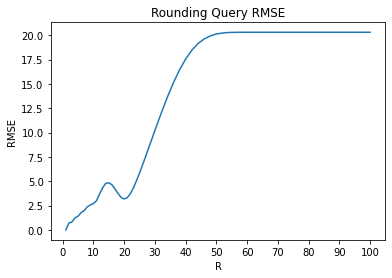

In [32]:
plt.plot(range(1, length + 1), round_df[0]);
plt.title("Rounding Query RMSE");
plt.xlabel("R");
plt.ylabel("RMSE");
plt.xticks(np.arange(11) * 10);

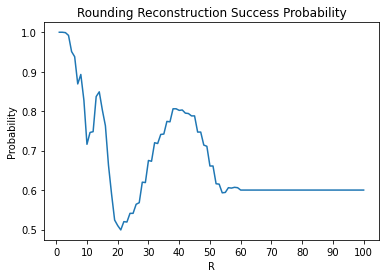

In [33]:
plt.plot(range(1, length + 1), round_df[1]);
plt.title("Rounding Reconstruction Success Probability");
plt.xlabel("R");
plt.ylabel("Probability");
plt.xticks(np.arange(11) * 10);

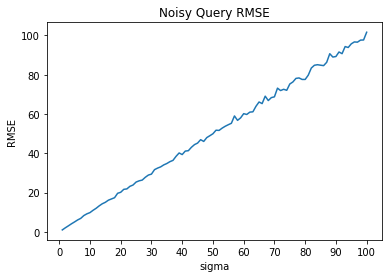

In [34]:
plt.plot(range(1, length + 1), noise_df[0]);
plt.title("Noisy Query RMSE");
plt.xlabel("sigma");
plt.ylabel("RMSE");
plt.xticks(np.arange(11) * 10);

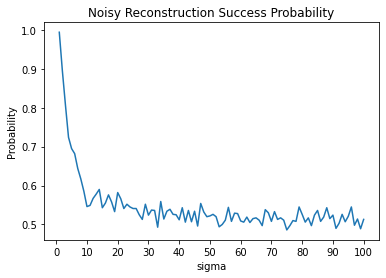

In [36]:
plt.plot(range(1, length + 1), noise_df[1]);
plt.title("Noisy Reconstruction Success Probability");
plt.xlabel("sigma");
plt.ylabel("Probability");
plt.xticks(np.arange(11) * 10);

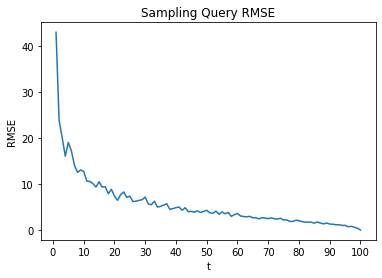

In [37]:
plt.plot(range(1, length + 1), sample_df[0]);
plt.title("Sampling Query RMSE");
plt.xlabel("t");
plt.ylabel("RMSE");
plt.xticks(np.arange(11) * 10);

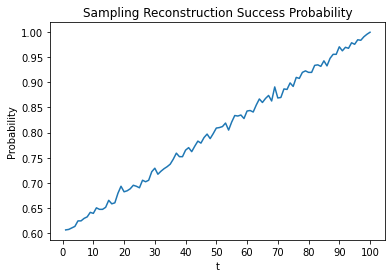

In [38]:
plt.plot(range(1, length + 1), sample_df[1]);
plt.title("Sampling Reconstruction Success Probability");
plt.xlabel("t");
plt.ylabel("Probability");
plt.xticks(np.arange(11) * 10);